In [24]:
from collections import deque
from dataclasses import dataclass
from graphviz import Digraph
from typing import NamedTuple


class State(NamedTuple):
    """
    True = entity is on the starting side
    False = entity is on the opposite side
    """

    wolf: bool = True
    goat: bool = True
    cabbage: bool = True
    farmer: bool = True

    def is_final(self) -> bool:
        """Check that all the animals and farmer have reached the opposite side."""
        return all(not value for value in self)

    def is_valid(self) -> bool:
        """Check if a state is valid.

        A state is invalid if:
        - The wolf can't be left alone with the goat, or the goat with the cabbage if the farmer is not present.

        Returns:
            True if state is valid, False otherwise
        """
        # We only check the side where the farmer is not present
        state = self.reverse() if self.farmer else self
        if (state.wolf and state.goat) or (state.goat and state.cabbage):
            return False
        return True

    def reverse(self) -> 'State':
        """Reverse a state.

        All values set to True become false and vice-versa.
        Useful to represent the state on the opposite bank.
        """
        return State(*tuple(not value for value in self))

    def actions(self) -> list[tuple[int, ...]]:
        """Generate all possible moves from the current state.

        The farmer has the possibility to bring back nothing from the opposite side,
        but we ignore this action when going as it generates just identic states.
        """
        actions = []
        state, direction = (self[:-1], -1) if self.farmer else (self.reverse(), +1)

        for index, value in enumerate(state):
            if value:
                action = [0, 0, 0, direction]
                action[index] = direction
                actions.append(tuple(action))
        return actions

    def result(self, action: tuple[int, ...]) -> 'State':
        """The state resulting from applying an action to the current state"""
        return State(*[bool(value + a) for value, a in zip(self, action)])

    @classmethod
    def action_to_string(cls, action: tuple[int, ...]) -> str:
        """Convert an action tuple to a human-readable description."""
        direction = '-' if action[3] == -1 else '+'
        s = State._make([bool(v) for v in action])

        return ', '.join(
            [f'{direction}{field}' for field, value in s._asdict().items() if value]
        ).join(('(', ')'))

    def __str__(self) -> str:
        return str(tuple(1 if value else 0 for value in self))

In [ ]:
@dataclass(frozen=True, slots=True)
class Node:
    state: 'State'
    parent: 'Node | None' = None
    action: tuple[int, ...] | None = None
    path_cost: int = 0

    def expand(self) -> list['Node']:
        """Generate all valid child nodes from this node."""
        children = []
        actions = self.state.actions()

        for action in actions:
            new_state = self.state.result(action)
            if new_state.is_valid():
                children.append(
                    Node(
                        state=new_state,
                        parent=self,
                        action=action,
                        path_cost=self.path_cost + 1,
                    )
                )
        return children

    def get_path(self) -> list[tuple[str | None, str]]:
        """Reconstruct the path from root to this node."""
        path = []
        node = self
        while node is not None:
            if node.action is not None:
                action = State.action_to_string(node.action)
            else:
                action = 'None'
            path.append((action, f'{node.state}'))
            node = node.parent
        return list(reversed(path))

    def __repr__(self) -> str:
        parent_state = str(self.parent.state) if self.parent else 'None'
        return (
            f'state={self.state}, Node(action={self.action}, '
            f'parent={parent_state}, path_cost={self.path_cost})'
        )

In [ ]:
def bfs_set(initial_state: State) -> tuple[Node | None, int]:
    """Breadth-first search with set of reached nodes."""
    root_node = Node(state=initial_state)
    frontier = deque([root_node])
    reached = set([initial_state])

    node_count = 1

    if root_node.state.is_final():
        return root_node, node_count

    while len(frontier) > 0:
        node = frontier.popleft()

        for child in node.expand():
            node_count += 1
            if child.state.is_final():
                return child, node_count
            elif child.state not in reached:
                frontier.append(child)
                reached.add(child.state)

    return None, node_count

In [34]:
res, node_count = bfs_set(State())
print(f'{res}, {node_count=}')
# if res is not None:
#     print(res.get_path())
res.get_path()

state=(0, 0, 0, 0), Node(action=(0, -1, 0, -1), parent=(0, 1, 0, 1), path_cost=7), node_count=18


[('None', '(1, 1, 1, 1)'),
 ('(-goat, -farmer)', '(1, 0, 1, 0)'),
 ('(+farmer)', '(1, 0, 1, 1)'),
 ('(-wolf, -farmer)', '(0, 0, 1, 0)'),
 ('(+goat, +farmer)', '(0, 1, 1, 1)'),
 ('(-cabbage, -farmer)', '(0, 1, 0, 0)'),
 ('(+farmer)', '(0, 1, 0, 1)'),
 ('(-goat, -farmer)', '(0, 0, 0, 0)')]

In [35]:
def bfs_visualize(initial_state: State) -> Digraph:
    dot = Digraph('graph_space')
    dot.graph_attr['rankdir'] = 'TB'

    root_node = Node(state=initial_state)
    frontier = deque([root_node])
    reached = set([initial_state])

    node_count = 1

    while len(frontier) > 0:
        node = frontier.popleft()
        node_id = str(hash(node.state))

        dot.node(
            node_id,
            label=str(node.state),
            penwidth=('3' if node.state.is_final() else '1'),
        )

        for child in node.expand():
            node_count += 1
            if child.state not in reached:
                frontier.append(child)
                reached.add(child.state)

            child_id = str(hash(child.state))
            dot.edge(node_id, child_id, label=State.action_to_string(child.action))

    print(f'Node generated: {node_count}')
    return dot

Node generated: 19


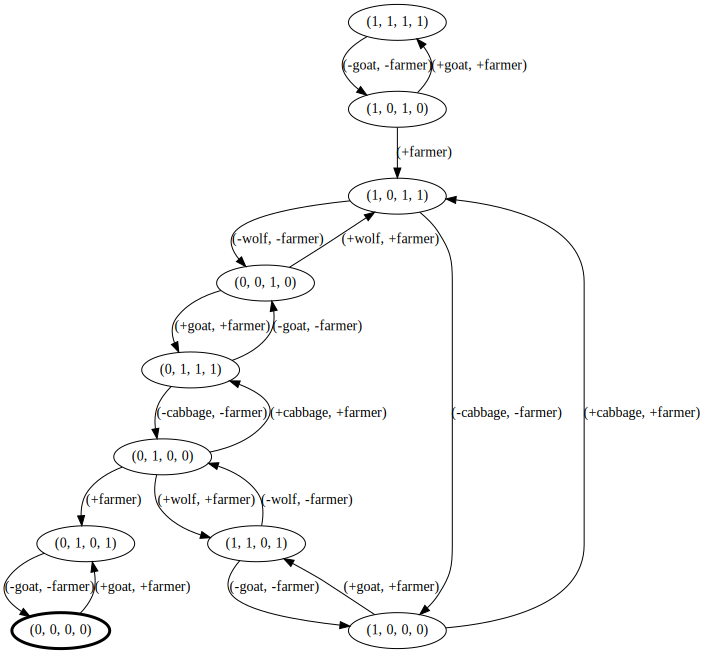

In [36]:
graph_space = bfs_visualize(State())

graph_space.render(directory='dot-output', format='pdf').replace('\\', '/')
graph_space